# Fermionic bath code: Box initialization

In [63]:
using SpecialFunctions
using Plots
using QuadGK
using BenchmarkTools

In [64]:
tₑ=1 #electron bandwidth= = σ
tB =3 #bath bandwidth
a1=2  #lattice constant
λ= 1 #system bath coupling
Tₑ=0# electron temperature
Temp_bath= 1.2 #the bath temperature
μ = 1  # chemical potential of the electron
μbath = 1 #chem potential of the bath



#time-simulation parameters
h= 0.1 #the time spacing
Time_max = 50 #the net time
N𝑡= Int(floor(Time_max/h)) #


#volume parameters
sitenum = 20 #gives the no. of sites in the lattice
a2=2*π*(1/(sitenum*a1)) #reciprocal space lattice constant
V_ph = collect(-0.5*sitenum*a2:a2:0.5*a2*(sitenum+1))

21-element Array{Float64,1}:
 -1.5707963267948966
 -1.413716694115407
 -1.2566370614359172
 -1.0995574287564276
 -0.9424777960769379
 -0.7853981633974483
 -0.6283185307179586
 -0.47123889803846897
 -0.3141592653589793
 -0.15707963267948966
  0.0
  0.15707963267948966
  0.3141592653589793
  0.47123889803846897
  0.6283185307179586
  0.7853981633974483
  0.9424777960769379
  1.0995574287564276
  1.2566370614359172
  1.413716694115407
  1.5707963267948966

In [65]:
N𝑡= Int(floor(Time_max/h))

500

### Block for defining Green's functions and convolutions for the electrons

In [66]:

function ϵₑ(k)
    return tₑ*(1-cos(V_ph[k]*a1))           #(1-cos(V_ph[k]*a1))
end


function G₀ᴿ(k,t1,t2)
    if t1>=t2
        return -im*exp(-im*ϵₑ(k)*(t1-t2)*h)
    else
        return 0
    end
end

    #prints 0 for t1<t2

function G₀ᴷ(k,t1,t2,Telectron,μ)

    return -im*tanh((ϵₑ(k)-μ)/(2*Telectron))*exp(-im*ϵₑ(k)*(t1-t2)*h)
end


## Convolution function definition

function Fₑ(k,t₁,t₂)
    if t₁>t₂
        return sum(t->Σₑᴿ[t₁,t]*Gᴿmatrix[k][t,t₂]*h, collect(t₂:t₁))
    elseif t₁==t₂
        return 0
    else
        return "You're convoluting in the opposite direction. Possible error at RR/electron conv"
    end
end

function RKₑ(k,t1,t2) #∫₀ᵗ Σₑᴿ⋅Dᴷ
    if t1>1
        sum=0
        for i=1:t1
            sum = sum+Σₑᴿ[t1,i]*Gᴷmatrix[k][i,t2]*h
        end
        #result1 = sum(t->Σₑᴿ[t1,t]*Gᴷmatrix[k][t,t2]*h, collect(1:t1))
        return sum
    else
        return 0
    end
end

function KAₑ(k,t1,t2) #∫₀⋅Dᴿ
    if t2>1
        sum=0
        for i=1:t2
            sum=sum+ Σₑᴷ[t1,i]* conj(Gᴿmatrix[k][t2,i]) * h
        end
        #result1 = sum( t->Σₑᴷ[t1,t]* conj(Gᴿmatrix[k][t2,t]) * h, collect(1:t2) )
        return sum
    else
        return 0
    end
end


KAₑ (generic function with 1 method)

In [67]:
Σᴿ(t1,t2) =-im*(λ^2)*1*(1/(tB))*(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))*(t1>t2)
J(ω) = (2/tB)*sqrt( 1- (ω/(2*tB))^2 )  #changed a -ve sign here 
σᴷ(ω) = -im*(λ^2)*J(ω)*tanh((ω-μbath)/(2*Temp_bath))#*(1/(2*π))

function Σᴷ(t1,t2)
    dω=(1/1000)*4*tB
    steps = collect(-2*tB:dω:2*tB)
    result=0
    for ω in steps
        result = result + dω*σᴷ(ω)*exp(-im*ω*(t1-t2)*h)
    end
    return result/(2*π)
end#-ve sign miss

Σᴷ (generic function with 1 method)

In [68]:
Gᴿmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Gᴷmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Σₑᴿ = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)

Σₑᴷ = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)

505×505 Array{Complex{Float64},2}:
       0.0-1.0im        …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.198669-0.980067im      0.0+0.0im  0.0+0.0im  0.0+0.0im
  -0.38752-0.911695im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.555549-0.799592im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.693452-0.651497im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.794304-0.477328im   …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.853967-0.288149im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.871164-0.0951349im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.847281+0.0913283im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.785949+0.262312im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.692503+0.410723im   …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.573417+0.531422im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 -0.435784+0.62113im       0.0+0.0im  0.0+0.0im  0.0+0.0im
          ⋮             ⋱                        
       0.0+0.0im           0.0+0.0im  0.0+0.0im  0.0+0.0im
       0.0+0.0im           0.0+0.0im  0.0+0.0im  0.0+0.0im
       0.0+0.0im        …  0.0

In [69]:
matinit = function ()
    for i=1:length(V_ph)+2
        Gᴿmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Gᴷmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
    end
end

#27 (generic function with 1 method)

In [70]:

######### Box Initialization ##########
boxinitindex=1

boxinit=function()

    for k =1:length(V_ph)
        for i=1:N𝑡
            Gᴿmatrix[k][i,i] = -im #exactly true           ## Gr(t,t)≂̸0
        end
    end



    ######## Box Initialization ############

    #GF Initialization

    for k=1:length(V_ph)
        for i=1:boxinitindex
            for j=1:boxinitindex
                Gᴿmatrix[k][i,j] = G₀ᴿ(k,i,j)
                Gᴷmatrix[k][i,j] =  G₀ᴷ(k,i,j,Tₑ,μ)

            end
        end
    end

end

#29 (generic function with 1 method)

In [71]:
### Code to update the Sigma R, Sigma K matrix

for i=1:N𝑡
    Σₑᴿ[i,1] = Σᴿ(i,1)
end

for j=2:N𝑡
    for i=j:N𝑡
        Σₑᴿ[i,j] = Σₑᴿ[i-j+1,1]
    end
end


for i=1:N𝑡
    Σₑᴷ[i,1] = Σᴷ(i,1)
end

for i=1:N𝑡
    Σₑᴷ[1,i] = Σᴷ(1,i)
end

for j=1:N𝑡
    for i=j:N𝑡
        Σₑᴷ[i,j] = Σₑᴷ[i-j+1,1]
    end
end

for j=1:N𝑡
    for i=j:N𝑡
        Σₑᴷ[j,i] = Σₑᴷ[1,i-j+1]
    end
end

# GF updates


In [72]:
Σₑᴿ[10,10]

-0.0 - 0.0im

In [73]:
matinit()
boxinit()

In [74]:

testrange = 250
####### Gr evolution #########
for i=boxinitindex:testrange     ### The diagonal value #should probably start from 2
    # Update GR, GK edges
    for k = 1 : length(V_ph)
        for j=1:i
            Gᴿmatrix[k][i+1,j] = im*G₀ᴿ(k,i+1,i)*Gᴿmatrix[k][i,j] + (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j))+ (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j))#+ (h/2)* G₀ᴿ(k,i+1,i+1)*Fₑ(k,i+1,j)
        end
    end
end

######### GK evolution ##############

for i=boxinitindex:testrange     ### The diagonal value #should probably start from 2

    # Update GR, GK edges
    for k = 1 : length(V_ph)
        for j=1:i
            Gᴷmatrix[k][i+1,j] = im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,j]+ (h/2) * G₀ᴿ(k,i+1,i) * ( RKₑ(k,i,j) + KAₑ(k,i,j) )#+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,j) + KAₑ(k,i+1,j) )   
            Gᴷmatrix[k][j,i+1] = - conj(Gᴷmatrix[k][i+1,j]) # iGᴷ is hermitian  ⟹ iGᴷ(1,2) = conj((iGᴷ(2,1)) ⟹ Gᴷ(1,2) = - conj(Gᴷ(2,1))
        end
    end
    

    ############## Diagonal terms update #############
    #Update GK(t+ϵ,t+ϵ) i.e GK(i+1,i+1) here  - needs Σₑᴿ on the i+1 block edges  i.e.
    for k=1:length(V_ph)
        Gᴷmatrix[k][i+1,i+1] = im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,i+1]+ (h/2)*G₀ᴿ(k,i+1,i)*(RKₑ(k,i,i+1) + KAₑ(k,i,i+1))#+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,i+1) + KAₑ(k,i+1,i+1) ) 
    end 
end

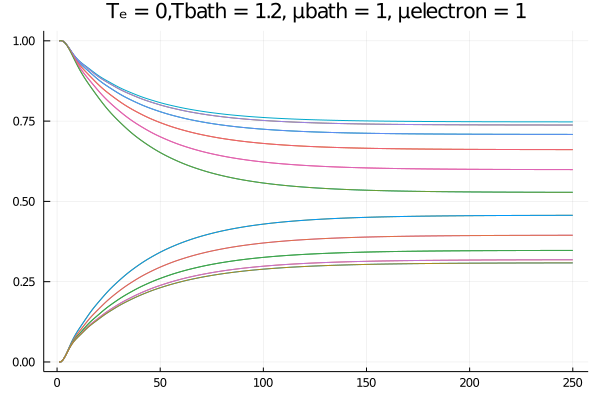

In [75]:
b2=[]
boxinitindex
testrange
list=[1 10]
for m=1:length(V_ph)
    b = Array{ComplexF64}(undef,testrange)
    for i=1:testrange
        #b[i] = Gᴿmatrix[m][i,1]
        b[i] = (imag(Gᴷmatrix[m][i,i])+1)*0.5
        #b[i] = Gᴷmatrix[m][i,i]
    end
    push!(b2,b)
end

b2
ser = collect(1:testrange)
p=plot(ser,real.(b2), legend=false,title = "Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ)",lw=1) 
## label="Tbath = $(Temp_bath)"
#scatter(ser,real.(b2[9]),legend=false)
#scatter(ser,real.(b2[3]),title="highest level",legend=false)


# Comparison with thermal distribution

In [76]:
fermi = function (e,T,μ)
    return 1/(exp((e-μ)*(1/T))+1)
end

#31 (generic function with 1 method)

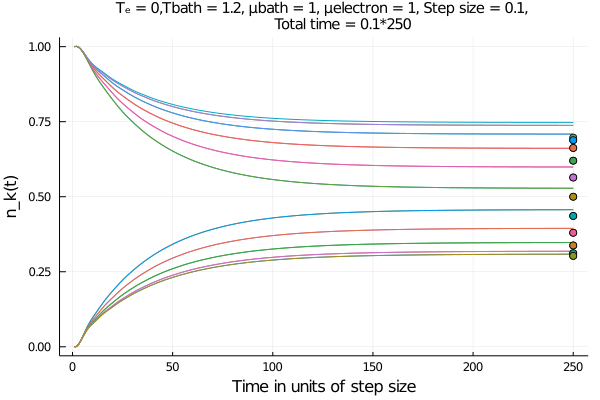

In [77]:
#scatter!([75.],[fermi(ϵₑ(2),Temp_bath,μbath)])

for k=1:length(V_ph)
   scatter!([testrange],[fermi(ϵₑ(k),Temp_bath,μbath)],xlabel="Time in units of step size", ylabel="n_k(t)",
        title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
        Total time = $(h)*$(testrange)",titlefontsize=10)
end
current()

In [82]:
#savefig("without_SC_terms_onepnttwo")

## Dispersion 

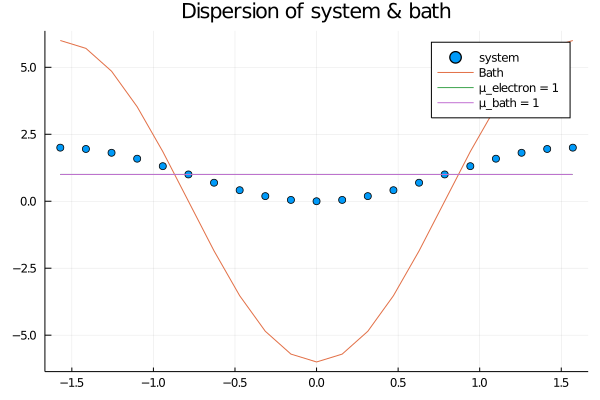

In [83]:
disp_electron= []
for m=1:length(V_ph)
    push!(disp_electron,ϵₑ(m))
end
disp_electron

x=collect(-π/a1:a2:π/a1)

scatter(x,disp_electron,label="system")
plot!(x, 2*-tB*cos.(x.*a1),title = "Dispersion of system & bath",label="Bath")
plot!(collect(-π/a1:1e-2:π/a1),μ.+collect(-π/a1:1e-2:π/a1).*0,label = "μ_electron = $(μ)")
plot!(collect(-π/a1:1e-2:π/a1),μbath.+collect(-π/a1:1e-2:π/a1).*0,label = "μ_bath = $(μbath)")

In [84]:
#savefig("dispersion")

Bath Badwidth, (s)=2.0x2

System Bath Coupling=1.0

Initial Energy Level=0.5

Initial Chem pot= -1 for blue, green, 1 for orange and yellow

Initial Temp=0.0

Bath Chem Pot= various as indicated

Bath Temp=various as indicated (0.0, 0.5, 1.0, 1.5)

Bath Spectral Function J(w)=2/s (sqrt(1-(w/2s)^2));


In [81]:
collect(1:10)

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

How Do i Understand what's the dependence of $\mu_{bath}$, $\mu_{system}$ and their respective temperature on thermalisation?